In [60]:
# Access the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from zipfile import ZipFile
import PIL
import tensorflow as tf

In [3]:
# Path to your dataset
train_dir = '/content/drive/MyDrive/Dataset/fruit-360/Training'
test_dir = '/content/drive/MyDrive/Dataset/fruit-360/Testing'
# Check if the data directory exists
if not os.path.exists(train_dir):
    print(f"Data directory {train_dir} does not exist.")
elif not os.path.exists(test_dir):
    print(f"Testing data directory {test_dir} does not exist.")
else:
    # Count the number of images
    train_dir_path = pathlib.Path(train_dir)
    train_image_count = len(list(train_dir_path.glob('*/*.jpg')))
    print(f"Number of images in training directory: {train_image_count}")

    # Count the number of images in testing directory
    test_dir_path = pathlib.Path(test_dir)
    test_image_count = len(list(test_dir_path.glob('*/*.jpg')))
    print(f"Number of images in testing directory: {test_image_count}")

Number of images in training directory: 3835
Number of images in testing directory: 1277


In [4]:
def count_images_per_class(directory):

  class_counts = {}
  for root, _, files in os.walk(directory):
    class_name = os.path.basename(root)
    if class_name:
      image_count = len(files)
      class_counts[class_name] = image_count
  return class_counts

# Example usage:
train_dir = '/content/drive/MyDrive/Dataset/fruit-360/Training'
test_dir = '/content/drive/MyDrive/Dataset/fruit-360/Testing'

train_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

print("Training set class counts:")
print(train_class_counts)

print("\nTesting set class counts:")
print(test_class_counts)

Training set class counts:
{'Training': 0, 'Strawberry': 490, 'Papaya': 490, 'Blueberry': 460, 'Banana': 488, 'Watermelon': 473, 'Pineapple': 488, 'Orange': 477, 'Apple': 469}

Testing set class counts:
{'Testing': 0, 'Watermelon': 157, 'Strawberry': 164, 'Orange': 160, 'Blueberry': 154, 'Banana': 166, 'Apple': 146, 'Papaya': 164, 'Pineapple': 166}


In [6]:
batch_size = 8
img_height = 100
img_width = 100

In [7]:
train_dir = '/content/drive/MyDrive/Dataset/fruit-360/Training' # Define train_dir with the correct path

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3835 files belonging to 8 classes.
Using 3068 files for training.


In [8]:
import tensorflow as tf

test_dir = '/content/drive/MyDrive/Dataset/fruit-360/Testing'

# Load the test dataset directly, without using validation_split or subset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Use the test directory here
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1277 files belonging to 8 classes.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3835 files belonging to 8 classes.
Using 767 files for validation.


In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Apple', 'Banana', 'Blueberry', 'Orange', 'Papaya', 'Pineapple', 'Strawberry', 'Watermelon']


In [11]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(8, 100, 100, 3)
(8,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [14]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [17]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 100, 100)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 100, 100)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 100, 100)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 100, 100, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 100, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │         16,392 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
model.evaluate(val_ds)

96/96 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - accuracy: 0.0534 - loss: 3.7870


[3.7216272354125977, 0.04693611338734627]

In [22]:
epochs = 12

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 769s 489ms/step - accuracy: 0.5710 - loss: 1.4444 - val_accuracy: 0.9935 - val_loss: 0.0625
Epoch 2/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 227s 482ms/step - accuracy: 0.9881 - loss: 0.0748 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 3/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 203s 484ms/step - accuracy: 0.9990 - loss: 0.0248 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 4/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 199s 475ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 5/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 243s 582ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 6/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 224s 484ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 7/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 186s 484ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 8/12
384/384 ━━━━━━━━━━━━━━━━━━━━ 183s 478ms/step - accuracy: 1.0000 -

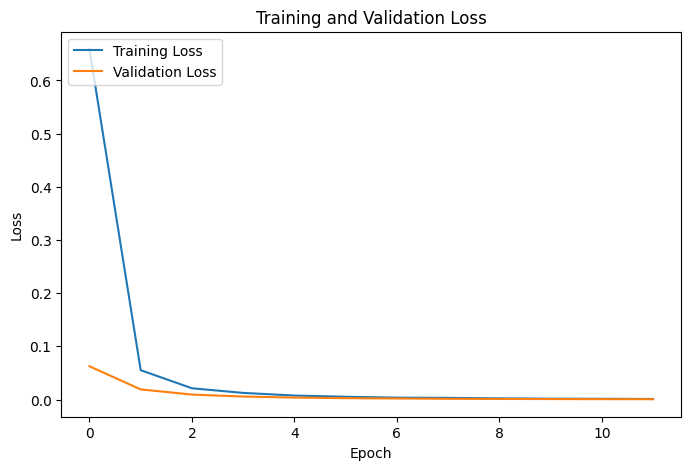

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [24]:
np.argmin(val_loss)

11

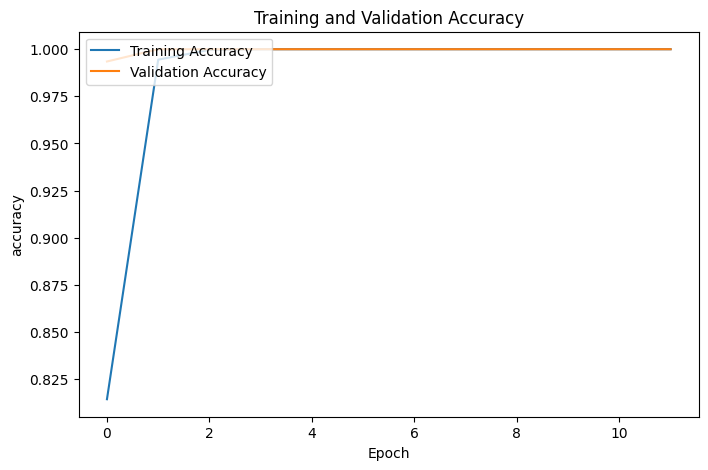

In [25]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")

plt.show()

In [26]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)

160/160 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 1.0000 - loss: 6.3555e-04
Test accuracy: 1.0


In [28]:
model.save("my_model1.keras")

In [58]:
model = tf.keras.models.load_model('my_model1.keras')
img = tf.keras.preprocessing.image.load_img(
    '/content/drive/MyDrive/Dataset/fruit-360/validation/Strawberry/12_100.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = preprocess_input(img_array)

In [59]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to Strawberry with a 98.39 percent confidence.


Accuracy were good but predictions were so wrong. Due to overfitting